Lennard-Jones Potential Example:

In [165]:
#IMPORTS
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.animation import FuncAnimation
from IPython.display import Image, display, clear_output

In [166]:
#Functions

#Interaction Kernel for Lennard-Jones Potential
def interaction_function(r, epsilon = 10, r_m = 1):
    phi = (epsilon)*(((r_m/r)**12) - (2*(r_m/r)**6))
    return phi
    
#Velocity Calculation Function
def compute_velocity(positions):
    N = len(positions)
    velocity = np.zeros_like(positions)
    for i in range(N):
        sum_term = np.zeros_like(positions[i])
        for j in range(N):
            if i != j:
                r = positions[j] - positions[i]
                distance = np.linalg.norm(r)
                phi = interaction_function(distance)
                sum_term += phi * r
        velocity[i] = sum_term / N
    return velocity

#Simple Visualization Function
def plot_agent_paths(x, xlim = (0, 10), ylim = (0, 10)):
    plt.figure(figsize=(10, 10))
    ax = plt.gca()

    if dim == 1:
        x_values = np.linspace(t_span[0], t_span[1], t_steps)
        for agent in range(N):
            ax.plot(x_values, x[:, agent, 0], c = 'blue')
        plt.xlim(t_span[0], t_span[1])
        plt.xlabel('Time')
        plt.ylabel('X Value')
    elif dim == 2:
        for agent in range(N):
            ax.plot(x[:, agent, 0], x[:, agent, 1], c = 'blue')
        for agent in x[len(x)-1]:
            plt.scatter(agent[0], agent[1], c = 'blue', s = 5)
        plt.xlim(xlim)
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
    else:
        print('Dimension Invalid')
        
    plt.ylim(ylim)
    plt.show()

#Update Function for 1 Dimensional Data
def update1D(frame):
    # Get the positions for the current frame
    current_x_positions = np.full((N,), x_values[frame])
    current_y_positions = position_log[frame, :, 0]
    current_positions = np.column_stack((current_x_positions, current_y_positions))
    scat.set_offsets(current_positions)

    for i, line in enumerate(lines):
        # Update line data to include all previous points
        line.set_data(x_values[:frame+1], position_log[:frame+1, i, 0])
    return lines + [scat]

#Update Function for 2 Dimensional Data
def update2D(frame):
    global x_trails, y_trails

    # Get the positions for the current frame
    current_positions = position_log[frame]

    # Update trail data
    x_trails = np.roll(x_trails, shift=-1, axis=1)
    y_trails = np.roll(y_trails, shift=-1, axis=1)
    x_trails[:, -1] = current_positions[:, 0]
    y_trails[:, -1] = current_positions[:, 1]

    
    # Update trails and agent positions
    for i, trail in enumerate(trails):
        trail.set_data(x_trails[i], y_trails[i])
    agents.set_offsets(current_positions)
    return trails + [agents]

def generate_particles(num_particles, dim, area_size, min_distance):
    particles = []
    attempts = 0
    max_attempts = 1000 * num_particles  # To prevent infinite loop

    while len(particles) < num_particles and attempts < max_attempts:
        # Generate a random point
        new_particle = np.random.rand(dim) * area_size
        # Check distance with all existing particles
        if all(np.linalg.norm(new_particle - p) >= min_distance for p in particles):
            particles.append(new_particle)
        attempts += 1

    if attempts == max_attempts:
        print("Max attempts reached, some particles may not be placed.")

    return np.array(particles)

In [180]:
start_time = time.time() #Runtime timer start

#Initial Conditions and Setup
dim = 1 #dimension for simulation
N = 4 #number of agents
t_span = (0, 100) #Time span for the simulation
t_steps = 1000 #Number of simulation steps within the time span
filename = f'lennardjones{dim}D.gif' #name of the saved animation gif file
area = 10
xlim = (-2, area + 2)
ylim = (-2, area + 2)
x = generate_particles(N, dim, area, 1.5)  # Initial positions based on dimension
steps = np.arange(0, t_steps, 1) #time step array
position_log = np.zeros((t_steps, N, dim)) #log of positions for each time step for visualization

#Euler's Method Position Calculations
for step in steps:
    position_log[step] = x
    x += compute_velocity(x) * (t_span[1]/t_steps)

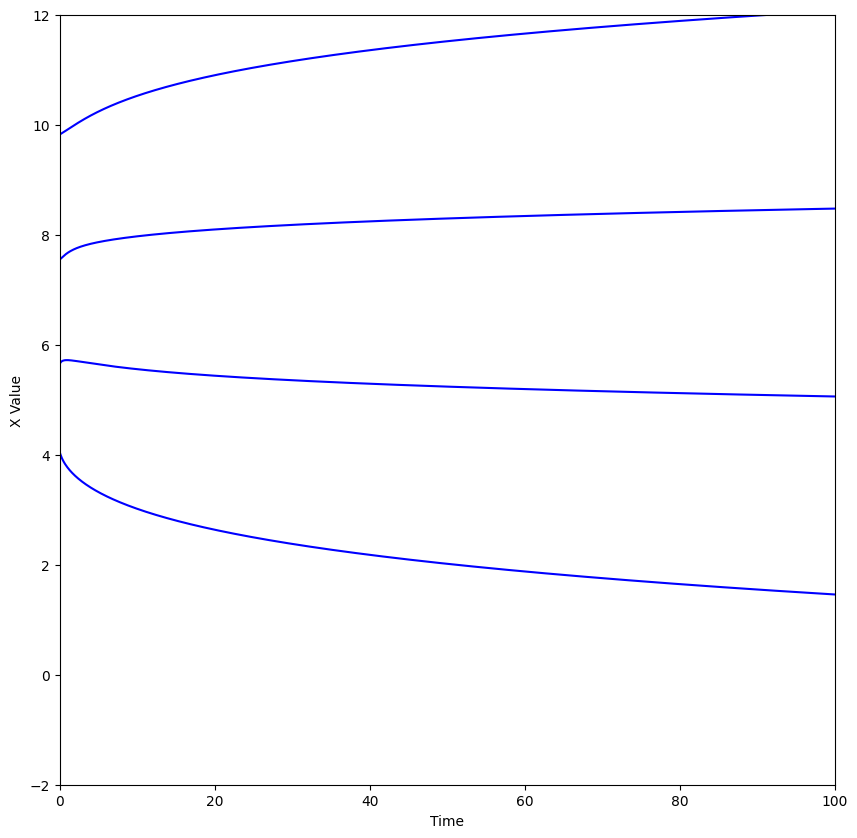

In [181]:
#Simple Visualization
plot_agent_paths(position_log, xlim, ylim)

In [ ]:
#Animation Creation
fig, ax = plt.subplots()
ax.set_ylim(ylim)

if dim == 1:
    #Initial Setup
    ax.set_xlim(t_span[0], t_span[1])
    x_values = np.linspace(t_span[0], t_span[1], t_steps) #x value array
    initial_x_positions = np.full((N,), x_values[0])
    initial_y_positions = position_log[0, :, 0]
    
    #Agent Lines and current points
    lines = [ax.plot([], [], lw=1, c = 'blue')[0] for _ in range(N)]
    scat = ax.scatter(initial_x_positions, initial_y_positions, s = 5)
    
    # Create animation
    ani = FuncAnimation(fig, update1D, frames=t_steps, blit=True, interval=1)
elif dim == 2:
    ax.set_xlim(xlim)

    # Agent trails and scatter plot
    trails = [ax.plot([], [], lw=1, c = 'blue', dashes = [2, 2])[0] for _ in range(N)]
    agents = ax.scatter(position_log[0, :, 0], position_log[0, :, 1], s = 5, c = 'blue')

    # Trails data
    trail_length = t_steps
    x_trails = np.full((N, trail_length), np.nan)
    y_trails = np.full((N, trail_length), np.nan)

    # Create animation
    ani = FuncAnimation(fig, update2D, frames=t_steps, blit=True, interval=1)
else:
    print('Dimension Invalid')

In [ ]:
#Save animation
ani.save(filename, writer='pillow', fps=((t_steps/t_span[1])*2))

#Display animation
display(Image(filename))

#Total Runtime
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")